In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
# Install pyglmnet if not already installed
!pip install pyglmnet
from pyglmnet import GLM # Now import pyglmnet after installation
from sklearn.preprocessing import StandardScaler

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

#%matplotlib qt5

#define custom functions:

<ipython-input-2-f6543982176a>:9: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [3]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [4]:
#Distribution and skewness
def distskew(dataset,feature):
    fig = plt.figure()
    sns.distplot(dataset[feature], fit=norm);
    return("Skewness = ",skew(dataset[feature].dropna()))

In [5]:
# Scatter plot
def scatplot(a,b):
    scatplotdata = pd.DataFrame({"x":a, "y":b})
    scatplotdata.plot(x = "x", y = "y", kind = "scatter")
    return()

In [7]:
#Import data
train = pd.read_csv("/content/train.csv")  #this is the initial X matrix
test = pd.read_csv("/content/test.csv")

()

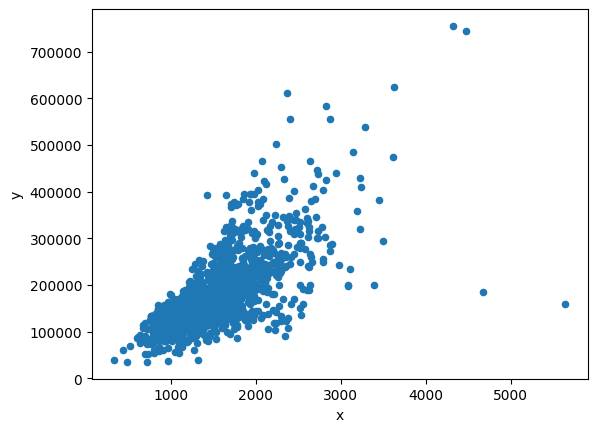

In [8]:
scatplot(train["GrLivArea"],train["SalePrice"])

<ipython-input-4-e877afb9892f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature], fit=norm);


('Skewness = ', 4.1179773827954875)

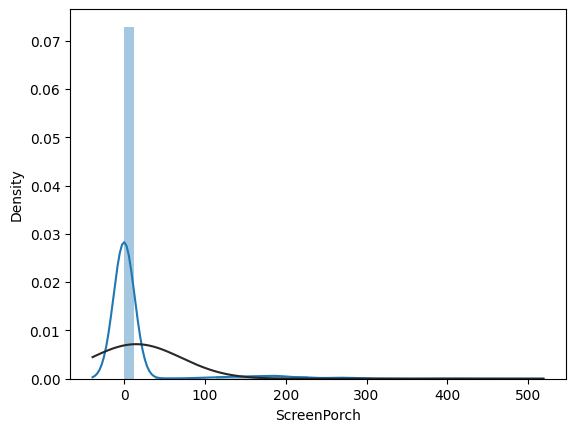

In [9]:
distskew(train,"ScreenPorch")

In [10]:
#Remove outliers
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

#train = train.drop(train[train['GrLivArea'] > 4000].index)
#train = train.drop(train[train['TotalBsmtSF'] == 0].index)

train = train.reset_index()

()

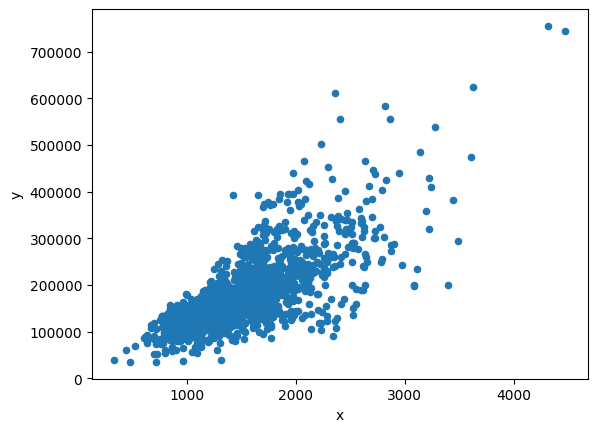

In [11]:
scatplot(train["GrLivArea"],train["SalePrice"])

In [12]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#train.loc --> loc works by looking the labels of the index
#the above operations then will extract all the data between
#the column 'MSSubClass' and 'SaleCondition' both  included

#all_data.head() #as you can see the ID and SalePrice column disappeared



prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#here we can list all the data by each types
#data_by_types = all_data.columns.to_series().groupby(all_data.dtypes).groups

In [14]:
all_data = all_data.drop("BsmtFinSF1", axis=1)
all_data = all_data.drop("BsmtFinSF2", axis=1)

all_data = all_data.drop("FullBath", axis=1)
all_data = all_data.drop("HalfBath", axis=1)
all_data = all_data.drop("BsmtFullBath", axis=1)
all_data = all_data.drop("BsmtHalfBath", axis=1)

In [15]:
# Create a new feature to handle the zero values of TotalBsmtSF
#all_data["ZeroBsmt"] = 0
#all_data.loc[all_data["TotalBsmtSF"] == 0,"ZeroBsmt"] = 1

In [16]:
#avgTotalBsmtSF = all_data["TotalBsmtSF"].mean()
#all_data.loc[all_data["TotalBsmtSF"] == 0,"TotalBsmtSF"] = avgTotalBsmtSF

In [17]:
# Add the living areas and basement aread to create a new feature TotArea
all_data["TotArea"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]

In [18]:
#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index



#for all the numeric features, calculate the skewness
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#exctract the features with skewness higher than 75%
skewed_feats = skewed_feats[skewed_feats > 0.1]
skewed_feats = skewed_feats.index

#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train[skewed_feats] = np.log1p(train[skewed_feats])

In [20]:
# Use axis=1 to specify dropping columns
all_data = all_data.drop("BsmtFinType1", axis=1)
all_data = all_data.drop("2ndFlrSF", axis=1)
all_data = all_data.drop("BedroomAbvGr", axis=1)

all_data = all_data.drop("LowQualFinSF", axis=1)
all_data = all_data.drop("3SsnPorch", axis=1)
#all_data = all_data.drop("PoolArea", axis=1)

#all_data = all_data.drop("GrLivArea", axis=1)
#all_data = all_data.drop("TotalBsmtSF", axis=1)

In [21]:
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

#pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

# Normalize the features (this does not seem to help: increases error)
#all_data = all_data.apply(lambda x: x/np.sqrt(sum(x**2)))

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [22]:
#distskew(all_data,"ScreenPorch")

()

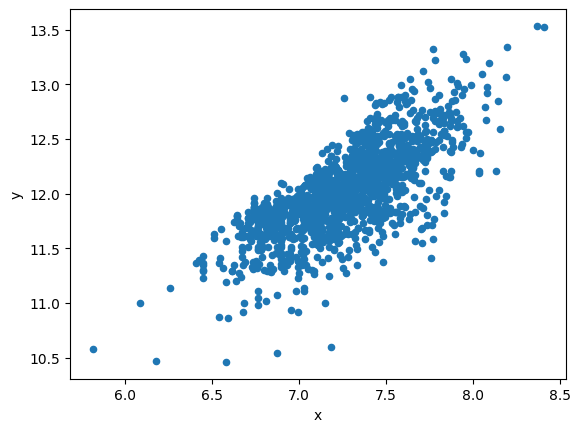

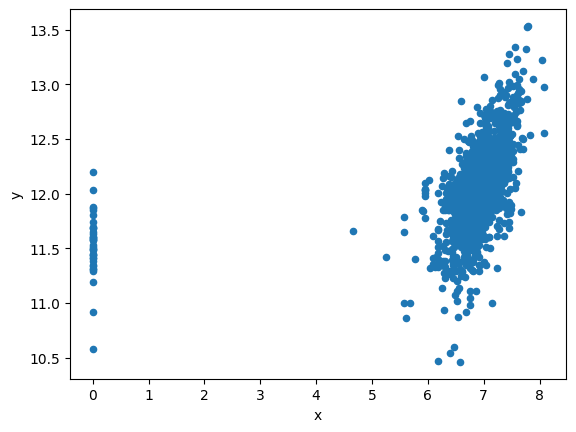

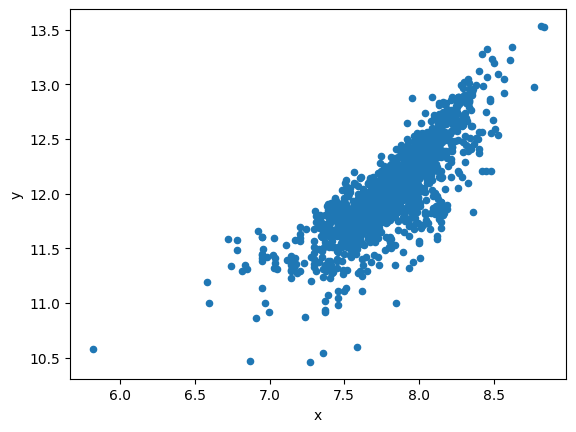

In [23]:
scatplot(train["GrLivArea"],train["SalePrice"])
scatplot(train["TotalBsmtSF"],train["SalePrice"])
scatplot(train["TotArea"],train["SalePrice"])


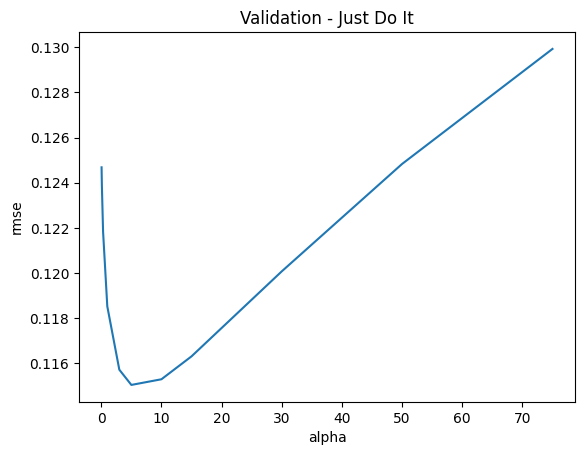

The min value of Ridge is  0.11503486101777989


In [24]:
#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [25]:
# Now fit Ridge model
model_ridge = Ridge(alpha = 5).fit(X_train, y)

<ipython-input-4-e877afb9892f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature], fit=norm);
<ipython-input-4-e877afb9892f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[feature], fit=norm);
<ipython-input-4-e877afb9892f>:4: UserWarning: 

`distplot` is a deprecated fu

('Skewness = ', -0.4646785815989929)

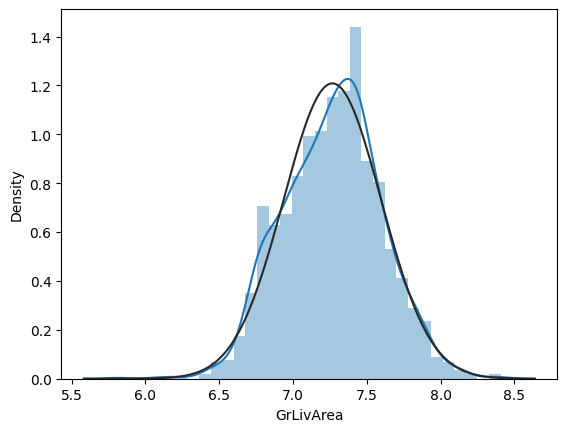

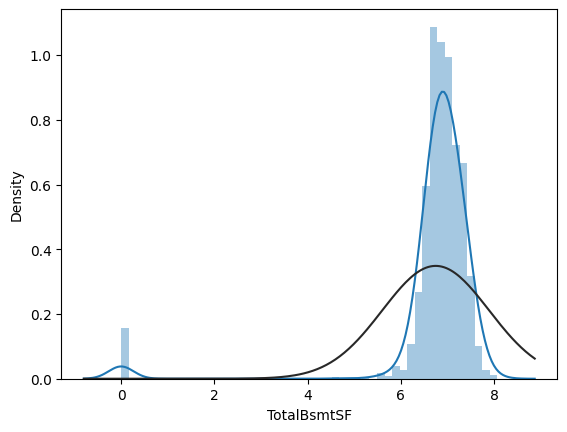

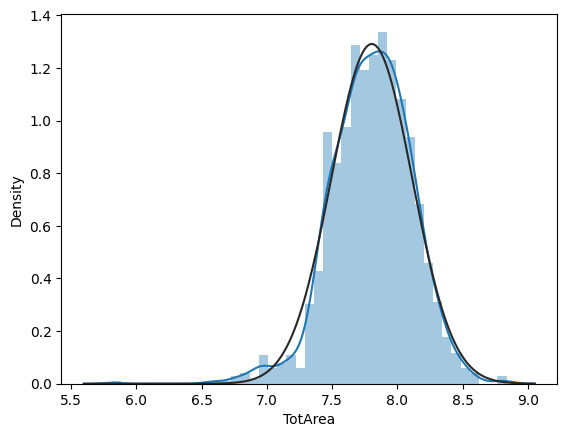

In [26]:
distskew(X_train,"GrLivArea")
distskew(X_train,"TotalBsmtSF")
distskew(X_train,"TotArea")

The min value of Lasso is  0.11106321990513804
Lasso picked 93 variables and eliminated the other 179 variables


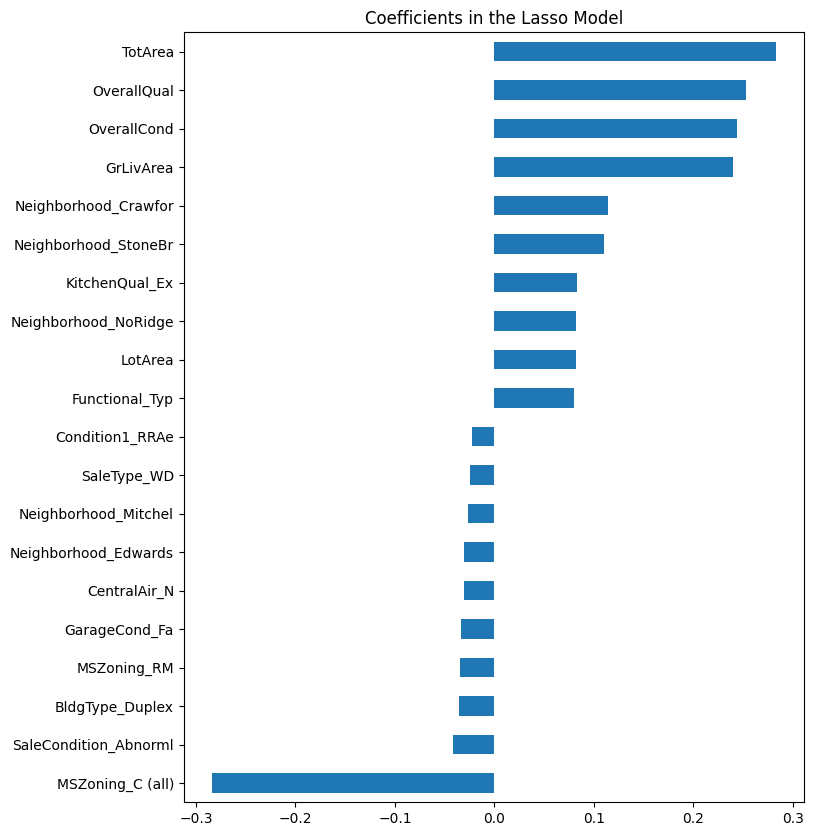

In [27]:
#Lasso:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


#Lasso choose performs also feature selection

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

#Also note that unlike the feature importance you'd get from a random forest
#these are actual coefficients in your model - so you can say precisely
#why the predicted price is what it is.
#The only issue here is that we log_transformed both the target
#and the numeric features
#so the actual magnitudes are a bit hard to interpret.


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)

#solution = pd.DataFrame({"id":test.Id, "SalePrice":preds_val})
#solution.to_csv("MDV_Lasso_v1.csv", index = False)


preds_log["residuals"] = preds_log["true"] - preds_log["preds"]



#preds_log.plot(x = "preds", y = "true",kind = "scatter")
#plt.title('Log Value ')
#plt.show()

#
#preds_val["residuals"] = preds_val["true"] - preds_val["preds"]
#preds_val.plot(x = "preds", y = "residuals",kind = "scatter")
#plt.title('Original Value in $')
#plt.show()

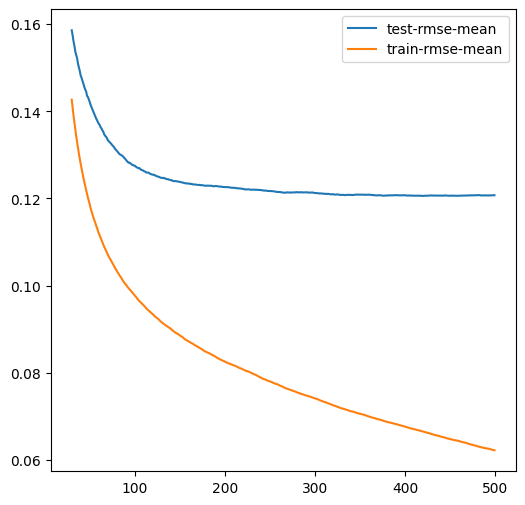

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
#Let's add an xgboost model to our linear model to see
#if we can improve our score:

#y = preds_log["residuals"]

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

In [29]:
#model_glm = GLM(distr='gaussian')
#scaler1 = StandardScaler().fit(X_train)
#scaler2 = StandardScaler().fit(X_test)
#model_glm.fit(scaler1.transform(X_train), y)



In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming 'X_train' and 'y' are your DataFrame and Series

# 1. Identify and convert object columns to numeric
for col in X_train.select_dtypes(include=['object']).columns:
    # Convert to numeric using appropriate method (e.g., one-hot encoding)
    # Here's an example using pandas get_dummies for categorical data:
    X_train = pd.get_dummies(X_train, columns=[col], prefix=[col], drop_first=True)

# 2. Ensure all data is numeric
X_train = X_train.astype(float)

# 3. Define and fit the GLM model
model_glm = sm.GLM(y, X_train, family=sm.families.Gaussian())
model_glm = model_glm.fit()

# 4. (Optional) Scale data if needed
# Create and fit scalers for X_train and X_test
# (Note: Scaling should be done after one-hot encoding)
scaler1 = StandardScaler().fit(X_train)

# Scale X_train for future predictions if needed
X_train_scaled = scaler1.transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


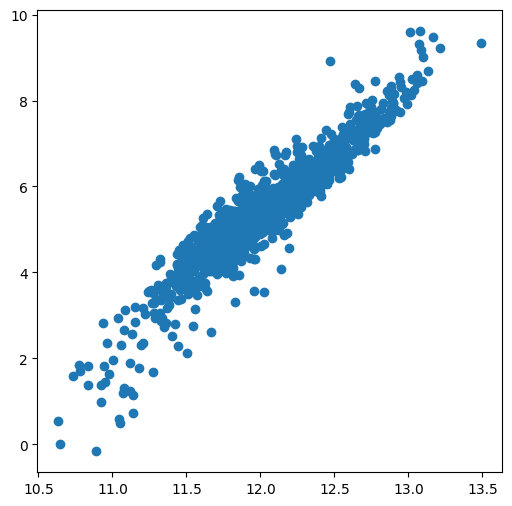

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# ... (your existing code) ...

# In the cell where you're using scaler2 (ipython-input-33-14d2501776bf):
# Before the plot line, uncomment and execute the following:
scaler2 = StandardScaler().fit(X_test)  # Define and fit scaler2

plt.plot(model_lasso.predict(X_test), model_ridge.predict(scaler2.transform(X_test)), 'o', label='original data')
plt.show()

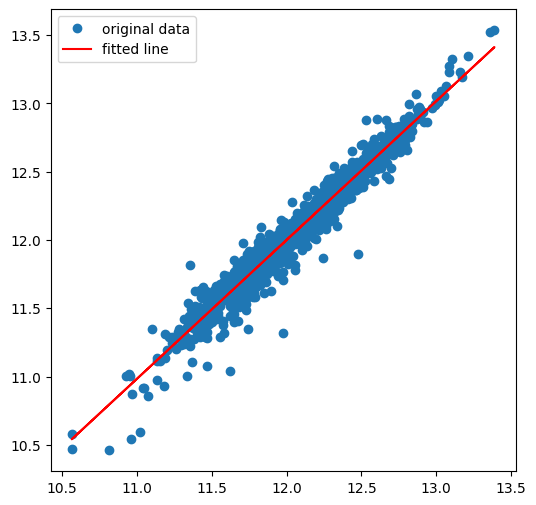

r-squared: 0.9530420348058152


In [36]:
x = 0.30*model_lasso.predict(X_train) + 0.30*model_ridge.predict(X_train) + 0.40*model_xgb.predict(X_train)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()
print("r-squared:", r_value**2)